# Herramienta de Pronóstico Asodulce

Desarrollada por
* Alejandro Herrán







In [18]:
#Variables:
model= "mul"# Definir si es multiplicativo o sumativo
desition= "mae"# Que indicador se va a usar como variable de desisión 
horizon = 12 #cuantos meses se van a pronosticar
archivo = "Demanda Asodulce.xlsx" #Nombre dle archivo
data = True # Poner True si se cuenta con mas de 25 datos



In [19]:
pip install statsmodels --upgrade

In [20]:
pip install pmdarima

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 385, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/comm

In [21]:

#Librerias 
import warnings  #evitar warnings
import pandas as pd  #trabajar tablas y estructuras de datos
from pandas import datetime # Fechas para pandas
from pandas import DataFrame # Tablas
import numpy as np #vectores y matrices y operaciones complejas
import matplotlib.pyplot as plt  #para trabajar graficos
import statsmodels.api as sm  #explorar modelos estadisticos
from statsmodels.tsa.seasonal import seasonal_decompose #descomposición de la serie
from sklearn.metrics import mean_squared_error, mean_absolute_error #biblioteca de aprendizaje automatico
from math import sqrt #operaciones matematica
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta #pip install python-dateutil
# Modelos
from statsmodels.tsa.ar_model import AutoReg #Autoregesión (AR)
from statsmodels.tsa.arima_model import ARMA # Autoregresión con media movil (ARMA)
import pmdarima as pm # Autoregresión Integrado con Media movil (ARIMA) y Autoregresión Integrado con Media movil Estacional (SARIMA)
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # Modelo Exponencial Simple
from statsmodels.tsa.api import ExponentialSmoothing #Modelo Holt y Modelo Holt-Winters
# Widgets
from google.colab import widgets

In [22]:
def Model_train(test,train,desition,trend=model,seas=model):

  Models=test.copy()
  mape={}
  mae={}
  mse={}
  Ts={}

  # ARMA
  Arma_fit = ARMA(train,order=(0,1)).fit()
  Models["ARMA"]=Arma_fit.predict(test.index.min(),test.index.max())
  mape["ARMA"]=(np.mean(np.abs((test - Models.ARMA) / test)) * 100)
  mae["ARMA"]=(mean_absolute_error(test, Models.ARMA))
  mse["ARMA"]=(mean_squared_error(test, Models.ARMA))
  Ts["ARMA"]=(sum(test - Models.ARMA)/mean_absolute_error(test, Models.ARMA))


  # Exponecial simple
  SE_fit = SimpleExpSmoothing(np.asarray(train)).fit()
  Models['SE'] = SE_fit.forecast(len(test))
  mape["SE"]=(np.mean(np.abs((test - Models.SE) / test)) * 100)
  mae["SE"]=(mean_absolute_error(test, Models.SE))
  mse["SE"]=(mean_squared_error(test, Models.SE))
  Ts["SE"]=(sum(test - Models.SE)/mean_absolute_error(test, Models.SE))

  # Holt
  Holt_fit = ExponentialSmoothing(np.asarray(train),trend=trend).fit()
  Models['Holt'] = Holt_fit.forecast(len(test))
  mape['Holt'] = (np.mean(np.abs((test - Models.Holt) / test)) * 100)
  mae['Holt'] = (mean_absolute_error(test, Models.Holt))
  mse['Holt'] = (mean_squared_error(test, Models.Holt))
  Ts['Holt'] = (sum(test - Models.Holt)/mean_absolute_error(test, Models.Holt))

  # Winter
  Winter_fit = ExponentialSmoothing(np.asarray(train) ,seasonal_periods=12 ,trend= trend, seasonal=seas).fit()
  Models['Winter'] = Winter_fit.forecast(len(test))
  mape['Winter'] =(np.mean(np.abs((test - Models.Winter) / test)) * 100)
  mae['Winter'] =(mean_absolute_error(test, Models.Winter))
  mse['Winter'] =(mean_squared_error(test, Models.Winter))
  Ts['Winter'] =(sum(test - Models.Winter)/mean_absolute_error(test, Models.Winter))

  # ARIMA y SARIMA
  if data:
    Arima_fit = pm.auto_arima(train, start_p=1, start_q=1,
                          test='adf', #prueba test Fuller
                          max_p=9, max_q=9, m=12, #se pueden cambiar p y q #M es la frecuencia
                          start_P=0, seasonal=True, #componente estacional
                          d=None, D=1, trace=False,
                          error_action='ignore',  
                          suppress_warnings=False, 
                          stepwise=True)
    Arima_fit.fit(train)
    Models['SARIMA'] = Arima_fit.predict(n_periods=len(test))

    mape['SARIMA'] = (np.mean(np.abs((test - Models.SARIMA) / test)) * 100)
    mae['SARIMA'] = (mean_absolute_error(test, Models.SARIMA))
    mse['SARIMA'] = (mean_squared_error(test, Models.SARIMA))
    Ts['SARIMA'] = (sum(test - Models.SARIMA)/mean_absolute_error(test, Models.SARIMA))
  
  best=1000000
  best_model=""
  if desition == "mae":
    for i in mae:
      if(best>=mae[i]):
        best=mae[i]
        best_model=i
  elif desition == "mape":
    for i in mape:
      if(best>=mape[i]):
        best=mape[i]
        best_model=i
  elif desition == "mse":
    for i in mse:
      if(best>=mse[i]):
        best=mse[i]
        best_model=i    
  print("Mejor modelo: ",best_model)
  print("Métricas")
  print("-"*50)
  print("MAPE :",mape[best_model])
  print("MAE :",mae[best_model])
  print("MSE :",mse[best_model])
  print("TS:",Ts[best_model])

  return best_model,mape[best_model],mae[best_model],mse[best_model],Ts[best_model]

In [23]:
def Model_predict(df,model_name,tiempo_pronosticar,trend=model,seas=model):
  #Se reentrenan los modelos pero con todo el dataframe
  if (model_name=="AR"):
    fecha=df.index[-1]+ relativedelta(months=tiempo_pronosticar)
    AR_fit = AutoReg(df,lags=35).fit()
    AR_forecast=AR_fit.predict(df.index.max(),fecha)
    return AR_forecast
  elif (model_name=="ARMA"):
    fecha=df.index[-1]+ relativedelta(months=tiempo_pronosticar)
    Arma_fit = ARMA(df,order=(0,1)).fit()
    ARMA_forecast=Arma_fit.predict(df.index.max(),fecha)
    return ARMA_forecast
  elif (model_name=="SARIMA"):
    models = pm.auto_arima(df, start_p=1, start_q=1,
                         test='adf', #prueba test Fuller
                         max_p=9, max_q=9, m=12, #se pueden cambiar p y q #M es la frecuencia
                         start_P=0, seasonal=True, #componente estacional
                         d=None, D=1, trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)


    fecha=df.index[-1]+ relativedelta(months=1)
    AS_forcast2 = models.predict(n_periods=tiempo_pronosticar)
    indexar_fecha = pd.date_range(fecha, periods = tiempo_pronosticar, freq='MS')
    AS_forcast = pd.Series(AS_forcast2, index=indexar_fecha)
    return AS_forcast
  elif (model_name=="SE"):
    fit_1 = SimpleExpSmoothing(df).fit()
    SE_forcast = fit_1.forecast(tiempo_pronosticar)
    return SE_forcast
  elif (model_name=="Holt"):
    fit_1 = ExponentialSmoothing((df) ,seasonal_periods=12 ,trend=trend).fit()
    Holt_forcast = fit_1.forecast(tiempo_pronosticar)
    return Holt_forcast
  elif (model_name=="Winter"):
    fit_1 = ExponentialSmoothing((df) ,seasonal_periods=12 ,trend=trend, seasonal=seas).fit()
    Winter_forcast = fit_1.forecast(tiempo_pronosticar)
    return Winter_forcast

# Selección y carga de los datos
Los datos utilizados para esta herramienta corresponden a la demanda real historia captada por la organización de 2010 a 2020. Esta se obtiene de la suma de los datos brindados por la empresa de Ventas, Stockouts y Backorders para cada mes.Los datos en cuestión se encuentran en un archivo de excel adjunto llamado "Demanda.xlsx", ya que es con este formato que lo brinda la encuesta. La importancia del uso de estos datos radica en que de estos dependen todas las operaciones futuras de la organización, ya que los datos pronosticados son el insumo con el que se desarrolla el Plan Maestro de Producción (MPS), con el cual se decide que producir, cuanto y cuando; por lo que contar con pronosticos precisos corresponde a una necesidad fundamental.

In [7]:
warnings.filterwarnings("ignore")
# Abrir archivos desde la computadora
from google.colab import files 
filename = files.upload()
df = pd.read_excel(filename[archivo]) #Lee el archivo y la hoja deseada
df.head(5) #Vista preliminar de los datos

Saving Demanda Asodulce.xlsx to Demanda Asodulce (5).xlsx


,Fecha,TAPAS,GRANULADO
0,2019-11-01,38956.0,33069.0
1,2019-12-01,42311.0,18428.0
2,2020-01-01,8013.0,12555.0
3,2020-02-01,19664.0,19335.0
4,2020-03-01,8999.0,14505.0


Los datos poseen una columna llamada fecha, esta columna debe transformarse en el índice del data frame. Paralelamente, es necesario que este índice se encuentre en formate date time, ya que es una requisito de algunos de los modelos que se utilizaran posteriormente. Finalmente, se elimna la columna fecha, ya que al estar como indice esta se vuelve innecesaria.

In [8]:
#Convertir la fecha en un formato pandas 
df.Timestamp = pd.to_datetime (df.iloc[:, 0], format = "%Y/%m/%d") #indexa la fecha, le da formato
df.index = df.Timestamp
#Eliminar la columna extra de Fecha
df=df.drop(["Fecha"],axis=1)

# Limpieza de los datos
Antes de crear los modelos, es necesario realizar una limpieza de los datos brindados por la empresa. En primer lugar es necesario eliminar todo valor negativo, ya que para efectos del forecast no existe algo como demanda negativa. Posteriormente se realiza una breve comprobación del tipo de datos, esto ya que, es posible que aunque en los presentes datos no existen presencia de valores nulos, es posible que los haya en un futuro.

In [9]:
#Convertir lo valores negativos en 0
df[df<0]=0
#Comprobar el formato de los datos
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25 entries, 2019-11-01 to 2021-11-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TAPAS      25 non-null     float64
 1   GRANULADO  25 non-null     float64
dtypes: float64(2)
memory usage: 600.0 bytes


# Visualización
A continuación se grafica la demanda para cada uno de los 30 SKU con el fin de observar de forma visual el comportamiento que esta posee. La demanda se organiza en widgets para cada SKU, con el fin de poder visualizarla de forma organizada e individual.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

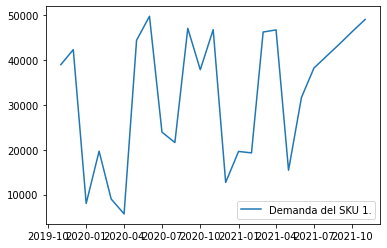

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

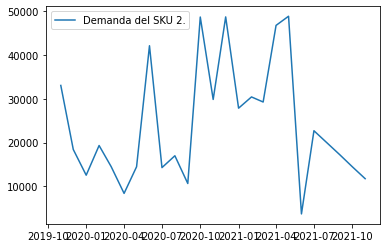

<IPython.core.display.Javascript object>

In [10]:
# Visualizar la Demanda
tb = widgets.TabBar([("SKU "+str(i+1)) for i in range(len(df.columns))])
for i in range(len(df.columns)):
  with tb.output_to(i, select=(i < 3)):
    plt.plot(df.iloc[:,i], label="Demanda del SKU {}.".format(i+1))
    plt.legend(loc='best')
    plt.show()

# Descomposición de la demanda
Las series de tiempo poseen dos componentes fundamentales, los cuales son de suma importancia conocer antes de recurrir a cualquier modelo. Estos componentes son la tendencia y la estacionalidad. A continuación se descompone la demanda de cada uno de los SKU, con el fin de visualizar la estos componentes de forma aislada.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

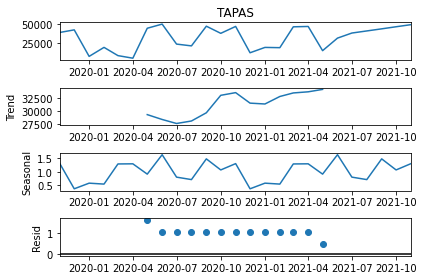

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

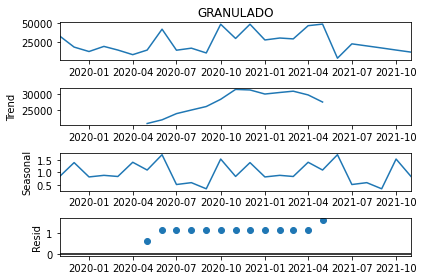

<IPython.core.display.Javascript object>

In [11]:
# Descomponer los datos

if data:
  tb2 = widgets.TabBar([("SKU "+str(i+1)) for i in range(len(df.columns))])
  for i in range(len(df.columns)):
    with tb2.output_to(i, select=(i < 3)):
      result = seasonal_decompose(df.iloc[:, i], model=model, freq=12)
      result.plot()
      plt.show()

Se realizó un análisis complementario de la tendencia, con el fin de determinar de manera contundente la presencia y orientación de esta.

# Datos de entrenamiento y validación

Con el fin de disminuir el riesgo al sobreajuste de un modelo al conjunto de datos obtenidos se recurre a un 

In [12]:
#@title Datos de entrenamiento y validación
#@markdown Con el fin de reducir los riesgos al sobreajuste del modelo al conjunto de datos se procede a realizar una división de la demanda en dos. La primera entrenamiento, la cual se utilizará para crear y entrenar el modelo. La segunda validación con la cual se probará cada uno de los modelos con el fin de encontrar el que mejor se ajusta al comportamiento observado. A continuación se puede parametrizar el porcentaje de datos que se utilizarán para entrenar.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

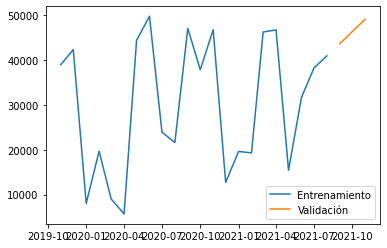

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

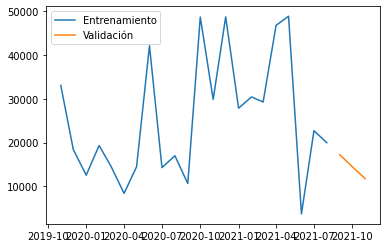

<IPython.core.display.Javascript object>

In [13]:
# Crear datos de entrenamiento y validación
porcentaje=0.9
train=pd.DataFrame()
test=pd.DataFrame()
tb4 = widgets.TabBar([("SKU "+str(i+1)) for i in range(len(df.columns))])
for i in range(len(df.columns)):
  train[("SKU "+str(i+1))]=df.iloc[:,i][0:int(porcentaje*(len(df)))] #entrenamiento
  test[("SKU "+str(i+1))]=df.iloc[:,i][int(porcentaje*(len(df))):]  #test
  with tb4.output_to(i, select=(i < 3)):
    plt.plot(train.iloc[:, i], label='Entrenamiento') #grafica los valores de entrenamiento
    plt.plot(test.iloc[:, i], label='Validación') #grafica los valores del test
    plt.legend(loc='best')
    plt.show()

# Creación y selección de los modelos de regresión
Con el fin de crear una herramienta para el forecast se recurre a una serie de modelos diferentes, donde cada uno es capaz de ajustarse a diferentes caracteristicas de los datos como la presencia o no de tendencia y/o estacionalidad. Estos modelos son:

* Autoregresivo (AR)
* Media Móvil (ARMA)
* Exponencial Simple (SE)
* Modelo Holt
* Modelo Winter
* Modelo Sarima

Cada uno de los modelos son creados utilizando los datos de entrenamiento previamente definidos, sobre estos se procede a validar el modelo calculando diferentes metricas como lo son el MAPE, MAE, MSE y TS. Finalmente, se gráfica el mejor modelo, la organización desea minimizar el MAPE, pero que por caracteristicas de la demanda (presencia de valores iguales a 0) no es posible de calcular para todos los datos, por lo que se procede a calcular el MAE para esta selección, ya que evalua lo mismo que el MAPE pero en terminos absoultos no porcentuales. 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mejor modelo:  Winter
Métricas
--------------------------------------------------
MAPE : 13.331579296323918
MAE : 6047.543861809431
MSE : 47587355.68576884
TS: -2.094889390863912
6047.543861809431
Empty DataFrame
Columns: [SKU 1]
Index: []


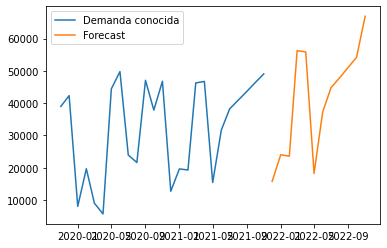

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mejor modelo:  Holt
Métricas
--------------------------------------------------
MAPE : 43.230881032971105
MAE : 5839.535853055481
MSE : 37201538.7237749
TS: -3.0
5839.535853055481
Empty DataFrame
Columns: [SKU 1, SKU 2]
Index: []


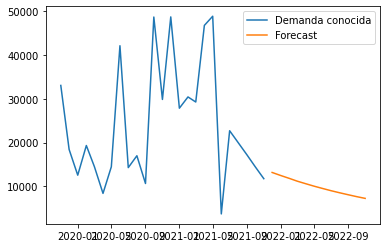

<IPython.core.display.Javascript object>

In [14]:
Predictions=pd.DataFrame()
maes =pd.DataFrame()
mapes = pd.DataFrame()
mses = pd.DataFrame()
tb5 = widgets.TabBar([("SKU "+str(i+1)) for i in range(len(df.columns))])
for i in range(len(df.columns)):
  with tb5.output_to(i):
    best_model,mape,mae,mse,Ts=Model_train(test.iloc[:,i],train.iloc[:,i],desition)
    Predictions[("SKU "+str(i+1))]=Model_predict(df.iloc[:,i],best_model,horizon,trend=model,seas=model) #Crea una prediccion del modelo elegido
    print(mae)
    maes[("SKU "+str(i+1))]= mae
    mapes[("SKU "+str(i+1))]= mape
    mses[("SKU "+str(i+1))]= mse
    print(maes)
    plt.plot(df.iloc[:, i], label='Demanda conocida') #grafica los valores de entrenamiento
    plt.plot(Predictions.iloc[:, i], label='Forecast') #grafica los valores del test
    plt.legend(loc='best')
    plt.show()

# Herramienta interractiva 
El siguiente apartado permite visualizar los datos obtenidos de la simulación, para cada SKU y en el periodo determinado por el usuario.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

El modelo de pornóstico que mejor se adapta al comportamiento de la demanda del SKU  es {}
 Se eligio con el {} como indicador de ajuste 
 las métricas de ajuste para este modelo son 
 MAPE: {} 
 MAE: {} 
 MSE: {}
 Los pronósticos los podrá encotrar el la pestaña llamada Forecast
 A continuación algunas medidas de tendencia central 
count       12.000000
mean     41298.543433
std      17122.513695
min      15746.234013
25%      23885.256637
50%      46311.201833
75%      54610.642072
max      66905.590875
Name: SKU 1, dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Forecast del SKU 1
--------------------------------------------------
2021-12-01    15746.234013
2022-01-01    23996.999172
2022-02-01    23550.029030
2022-03-01    56257.558006
2022-04-01    55853.125670
2022-05-01    18207.127749
2022-06-01    37199.638488
2022-07-01    44775.141247
2022-08-01    47847.262419
2022-09-01    51047.333652
2022-10-01    54196.480873
2022-11-01    66905.590875
Freq: MS, Name: SKU 1, dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

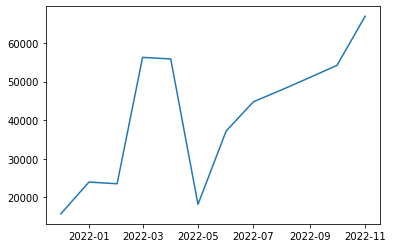

<IPython.core.display.Javascript object>

In [15]:
#@title Herramienta Interactiva Forecast

SKU =  1#@param {type:"integer"}
SKU=SKU-1
Periodo = 24 #@param {type:"slider", min:1, max:24, step:1}
tb5 = widgets.TabBar(["Análisis experto","Forecast","Visualización"])
with tb5.output_to(0):
  print("El modelo de pornóstico que mejor se adapta al comportamiento de la demanda del SKU  es {}\n Se eligio con el {} como indicador de ajuste \n las métricas de ajuste para este modelo son \n MAPE: {} \n MAE: {} \n MSE: {}\n Los pronósticos los podrá encotrar el la pestaña llamada Forecast\n A continuación algunas medidas de tendencia central ")
  print(Predictions.iloc[:Periodo,SKU].describe())
with tb5.output_to(1):
  print("Forecast del SKU",SKU+1)
  print("-"*50)
  print(Predictions.iloc[:Periodo,SKU])
with tb5.output_to(2):
  plt.plot(Predictions.iloc[:Periodo,SKU]) #grafica los valores del test
  plt.show()
  


In [16]:
Predictions.to_excel('Predictions.xlsx') #Guardar los archivos en un excel

In [17]:
Predictions


,SKU 1,SKU 2
2021-12-01,15746.234013,13174.863054
2022-01-01,23996.999172,12478.515441
2022-02-01,23550.029030,11818.972765
2022-03-01,56257.558006,11194.289728
2022-04-01,55853.125670,10602.623849
2022-05-01,18207.127749,10042.230031
2022-06-01,37199.638488,9511.455412
2022-07-01,44775.141247,9008.734493
2022-08-01,47847.262419,8532.584514
2022-09-01,51047.333652,8081.601090
